# Generative Deep Learning - Exploration

This is a notebook containing my exploration into the field of generative deep learning.

## Preliminary work

These linked notebook are preliminary work into various machine learning algorithms necessary to get the concept grounds covered:
- [Notebook 1]()
- [Notebook 2]()

## Introduction

The field of generative deep learning has always fascinated me (ever since I have seen the first [Google Deep Dream](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) examples, and the work of [Mario Klingemann](http://quasimondo.com/)), and saw an opportunity to deep dive into it while going into Semester 04 at CODE University. It developed into the first steps of research into an interactive installation done with artist [Diane Drubay](www.dianedrubay.com)

This being an ongoing project (outside of the semester scope), the final result will be available in a later period of time.

## Content 
1. [Deep learning](#Deep-learning)<br>
    1.1 [Load the cifar10 data](#Load-the-cifar10-data)<br>
    1.2 [Building the Model](#Building-the-Model)<br>
    1.3 [Compiling the Model](#Compiling-the-Model)<br>
    1.4 [Training the Model](#Training-the-Model)<br>
2. [Autoencoder and Variational Autoencoders](#Autoencoder-and-Variational-Autoencoders)
3. [GANs](#GANs)
4. [StyleGAN2 from Nvidia](#StyleGAN2)

# Deep-learning

This is the first real step into the direction of neural networks using keras. It can be considered as a warm-up.

In [1]:
import numpy as np
from keras.utils import to_categorical
from keras.datasets import cifar10
from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Load the cifar10 data

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 imagthees. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

It is noteworthy to tell that there are no <i>rows</i> or <i>columns</i> in this dataset, it's a <i>tensor</i> with four dimensions.

x_train, y_train are numpys arrays containing the image data <i>(32 x 32 px - 3 channel RGB colors)</i>

x_test, y_test are numpys arrays containing the integer labels in the range 0 to 9 for the class of each image.

In [2]:
num_classes = 10

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

A quick confirmation that the data shape is as expected to be

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

Showing the first 9 images of the dataset

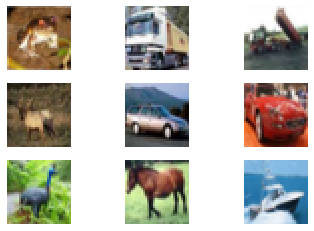

In [5]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
    plt.axis('off')
plt.show()

Image data are integers between 255 and 0 - for the neural network we need a data range from -1 to 1

In [9]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

The integer labeling of the images needs to be changed into one-hot-encoded vectors. If the class integer label of an image is <i>i</i>, then its one-hot encoding is a vector of length 10 (num_classes) that has 0s in all but the <i>i</i>th element which is 1. The new shapes of y_train and y_test are therefore (50000, 10) and (10000, 10)

In [10]:
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Building the Model

In Keras, there are two ways to define the structre of the neural network: a Sequential model or using the Functional API.

The Sequential model is used to create quickly a linear stack of layers. But we need networks with layers being able to pass data to multiple separate layers beneath it, or inversely, that a layer receives input from multiple layers above it.

Therefore the Functional API of Keras is being used to build the model.
We are using three different types of layer: <b>Input, Flatten, Dense</b>

The <b>Input</b> layer which is basically our entry point into the network. The network is being told the shape of each data element to expect as a tuple (32, 32, 3)

The <b>Flatten</b> layer which flattens our data into a vector of length 3072 (32 x 32 x 3). This is needed as the subsequent layer needs a flat input rather than a multidimensional array.

The <b>Dense</b> layer which is the most fundamental layer in any neural network. It contains a certain number of units densely connected by a single connection carrying a weight. The output from a given unit is the weighted sum of the input it receives from the previous layer, passed through an activation function ('relu') before being sent to the next layer. This activation function is critical to ensure the neural network can learn complex functions.


### Activation functions

An Activation function is a critical part of a neural network, ensuring the learning of complex functions. It is used to determine the output of the node, and is also known as Transfer Function.

- The <i>ReLU</i> activation function is defined to be zero if the input is negative and is otherwise equal to the input.
- The <i>LeakyReLU</i> activation function is almost the same as the ReLU, but returns a proportional negative number if the input is less than zero
- The <i>sigmoid</i> activation is useful for binary classification problems with one output unit or multilabel classification problems
- the <i>softmax</i> activation if one needs the total sum of the output from the layer to equal 1 (multiclass classification problems where each observation only belongs to exactly one class)

Right beneath is a visual indicator of the various types of activation functions

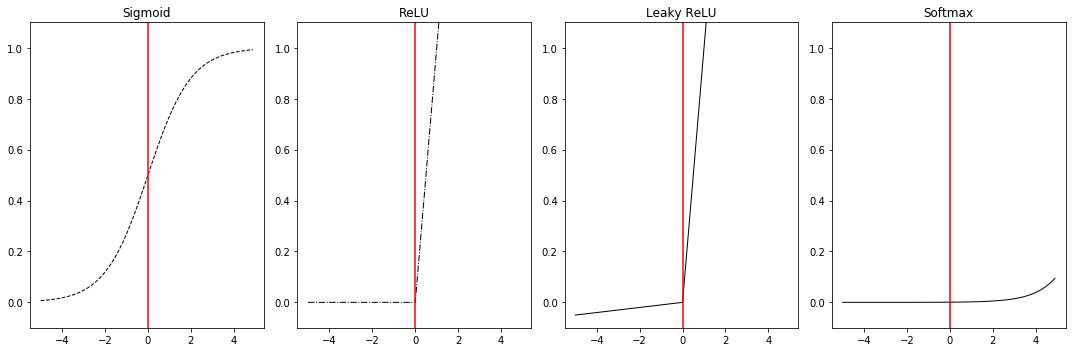

In [46]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x):
    return np.where(x > 0, x, x * 0.01)

def plot_zero_line(ax):
    return axes[ax].plot(np.zeros(len(x)), x, color='r')

x = np.arange(-5.0, 5.0, 0.1)

fig,axes=plt.subplots(nrows=1, ncols=4,figsize=(15,5))

axes[0].plot(x, sigmoid(x), color='k', lw=1, ls='--')
plot_zero_line(0)
axes[0].set_title('Sigmoid')
axes[1].plot(x, relu(x), color='k', lw=1, linestyle='-.')
plot_zero_line(1)
axes[1].set_title('ReLU')
axes[2].plot(x, leaky_relu(x), color='k', lw=1)
plot_zero_line(2)
axes[2].set_title('Leaky ReLU')
axes[3].plot(x, softmax(x), color='k', lw=1, ls='-')
plot_zero_line(3)
axes[3].set_title('Softmax')

for ax in axes:
    ax.set_ylim(-0.1, 1.1)
fig.tight_layout()
plt.show()

This is our Model

In [15]:
input_layer = Input(shape=(32, 32, 3))

x = Flatten()(input_layer)

x = Dense(units=200, activation='relu')(x)
x = Dense(units=150, activation='relu')(x)

output_layer = Dense(units=10, activation='softmax')(x)

model = Model(input_layer, output_layer)

## Compiling the Model

Here we compile the model with an optimizer (Adam) and a loss function.

The most commonly used loss functions are <i>mean squared loss</i> used to solve a regression problem (the output is continuous). If one is working on a classification problem where each observation only belongs to one class, use the <i>categorical cross-entropy</i>. And at last, if one is working on a binary classification problem with one output unit or a multilabel problem where each observation can belong to multiple classes, use <i>binary cross-entropy</i>


In [39]:
opt = Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Training the Model

In [40]:
model.fit(x_train, y_train, batch_size=32, epochs=10, shuffle=True)

Epoch 1/10
50000/50000 [==============================] - 4s 82us/step - loss: 1.8512 - accuracy: 0.3322
Epoch 2/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.6660 - accuracy: 0.4061
Epoch 3/10
50000/50000 [==============================] - 4s 73us/step - loss: 1.5865 - accuracy: 0.4357
Epoch 4/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.5358 - accuracy: 0.4541
Epoch 5/10
50000/50000 [==============================] - 4s 79us/step - loss: 1.4885 - accuracy: 0.4709
Epoch 6/10
50000/50000 [==============================] - 4s 76us/step - loss: 1.4596 - accuracy: 0.4800
Epoch 7/10
50000/50000 [==============================] - 4s 80us/step - loss: 1.4339 - accuracy: 0.4894
Epoch 8/10
50000/50000 [==============================] - 4s 74us/step - loss: 1.4088 - accuracy: 0.4991
Epoch 9/10
50000/50000 [==============================] - 4s 73us/step - loss: 1.3855 - accuracy: 0.5086
Epoch 10/10
50000/50000 [==============================

In [41]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               614600    
_________________________________________________________________
dense_2 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1510      
Total params: 646,260
Trainable params: 646,260
Non-trainable params: 0
_________________________________________________________________


## Evaluating the Model

The output of this method are categorical cross-entropy and accuracy on the test data (meaning the Model has never seen this data). The Model accuracy is around the same as with the training data.

In [47]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 1s 52us/step


[1.4361003894805908, 0.4959000051021576]

Below is a display of 10 randomly selected images with their predictions. We're on par with the accuracy, meaning that around of the images is correctly labelled.

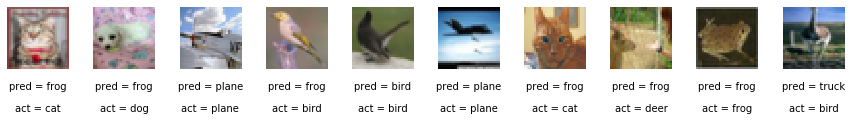

In [50]:
CLASSES = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
predictions = model.predict(x_test)
predictions_single = CLASSES[np.argmax(predictions, axis=-1)]
actuals_single = CLASSES[np.argmax(y_test, axis=-1)]

num_to_show = 10
indices = np.random.choice(range(len(x_test)), num_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, num_to_show, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'pred = ' + str(predictions_single[idx]), fontsize = 10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, 'act = ' + str(actuals_single[idx]), fontsize = 10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

# Autoencoder and Variational Autoencoders<a name="autoencoder" />

# GANs

# StyleGAN2